In [1]:
import d2lzh as d2l
import math
from mxnet import nd
import numpy as np
import torch

DATA_FILE = '/Users/arthur/code/source/algorithm/python-algorithms/dataset/airfoil_self_noise.dat'

%matplotlib inline

# Gradient Descent

## 一维梯度下降

In [2]:
def gd(df, x, eta=0.01, n=20):
    """
    梯度下降演示
    Params
        df: f的导数函数
        x: x的初始值
    """
    results = [x]
    for i in range(n):
        x = x - eta * df(x)
        results.append(x)
    print("After n iterations, x = {}".format(x))
    return results

In [5]:
def show_trace(f, res):
    n = max(abs(min(res)), abs(max(res)), 1)
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [f(x) for x in f_line])
    d2l.plt.plot(res, [f(x) for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')

After n iterations, x = 0.01152921504606847


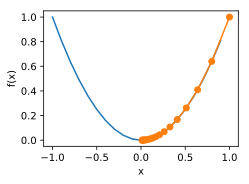

In [6]:
res = gd(lambda x: 2*x, x=1, eta=0.1)
show_trace(lambda x: x*x, res)

## 多维梯度下降

In [6]:
def train_2d(trainer, init=[-5, -2, 0, 0], eta=0.1, n=20):
    x1, x2, s1, s2 = init
    results = [(x1, x2)]
    for i in range(n):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2, eta)
        results.append((x1, x2))
    print('After {} iterations, x1={}, x2={}'.format(n, x1, x2))
    return results


def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

In [7]:
def f_2d(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2


def gd_2d(x1, x2, s1, s2, eta):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

After 20 iterations, x1=-0.057646075230342354, x2=-7.312316880125945e-05


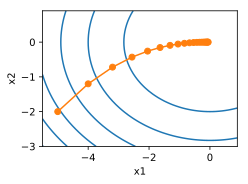

In [8]:
results = train_2d(gd_2d)
show_trace_2d(f_2d, results)

## 随机梯度下降

After 20 iterations, x1=0.33621625796180776, x2=-0.0007610876413888454


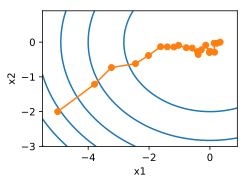

In [9]:
def sgd_2d(x1, x2, s1, s2, eta):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d, eta=0.1))

## 批量随机梯度下降

In [10]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import time

In [21]:
def get_data_ch7():
    data = np.genfromtxt(DATA_FILE, delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    features = nd.array(data[:1500, :-1])
    labels = nd.array(data[:1500, -1])
    return features, labels

features, labels = get_data_ch7()
features.shape


(1500, 5)

In [12]:
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

In [13]:
def train_ch7(trainer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.squared_loss
    # 初始化参数
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()

    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()
    
    ls = [eval_loss()]
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 反向传播求导
            with autograd.record():
                l = loss(net(X, w, b), y).mean()
            l.backward()
            # 根据导数调整模型参数
            trainer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start)) 
    d2l.set_figsize() 
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls) 
    d2l.plt.xlabel('epoch') 
    d2l.plt.ylabel('loss')
        

loss: 0.243936, 0.018067 sec per epoch
loss: 0.245652, 1.143483 sec per epoch
loss: 0.243215, 0.137477 sec per epoch


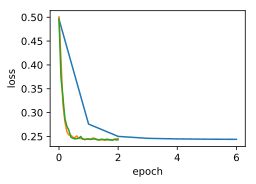

In [14]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)
train_sgd(0.005, 1)
train_sgd(0.05, 10)

## 带动量的梯度下降

In [15]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2, eta):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

After 20 iterations, x1=-0.9434666458139824, x2=-7.312316880125978e-05


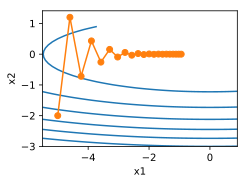

In [16]:
show_trace_2d(f_2d, train_2d(gd_2d, eta=0.4))

After 20 iterations, x1=-0.38781396819094793, x2=-1673.365108505695


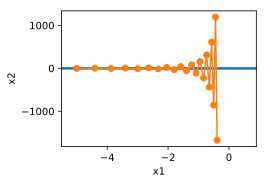

In [17]:
show_trace_2d(f_2d, train_2d(gd_2d, eta=0.6))

After 20 iterations, x1=-0.06284345503037861, x2=0.0012023355717834623


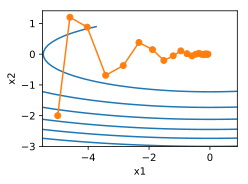

In [18]:
def momentum_2d(x1, x2, v1, v2, eta):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2


eta, gamma = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d, eta=0.4))

In [33]:
features, labels = get_data_ch7()


def init_momentum_states():
    v_w = nd.zeros((features.shape[1], 1))
    v_b = nd.zeros(1)
    return (v_w, v_b)


def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v = hyperparams['momentum'] * v + hyperparams['lr'] * p.grad
        p -= v

loss: 0.242965, 0.151391 sec per epoch


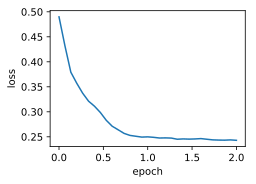

In [40]:
train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.99}, features, labels)

## Adagrad

After 20 iterations, x1=-5.49538800708935e-07, x2=-5.457723950339784e-10


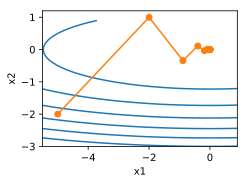

In [54]:
def adagrad_2d(x1, x2, s1, s2, eta=0.4):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2


def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2


show_trace_2d(f_2d, train_2d(adagrad_2d, eta=3))

In [59]:
def init_adagrad_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)


def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s += (p.grad ** 2)
        p -= hyperparams['lr'] * p.grad / nd.sqrt(s + eps)

loss: 0.242769, 0.171302 sec per epoch


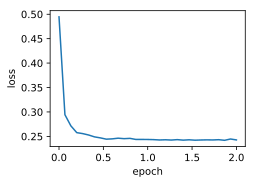

In [60]:
train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

## RMSPROP

After 20 iterations, x1=-0.7851786452266661, x2=0.0017963214143316146


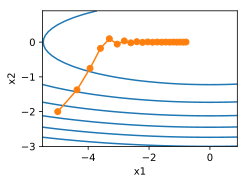

In [83]:
def rmsprop_2d(x1, x2, s1, s2, eta=0.4):
    g1, g2, eps, gamma = 0.2 * x1, 4 * x2, 1e-6, 0.9
    s1 = gamma * s1 + (1 - gamma) * (g1 ** 2)
    s2 = gamma * s1 + (1 - gamma) * (g2 ** 2)
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

show_trace_2d(f_2d, train_2d(rmsprop_2d, eta=0.2))

In [81]:
def init_rmsprop_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return s_w, s_b


def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s = gamma * s + (1 - gamma) * (p.grad ** 2)
        p -= hyperparams['lr'] * p.grad / nd.sqrt(s + eps)

loss: 0.265147, 0.193056 sec per epoch


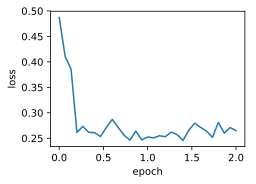

In [82]:
train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9}, features, labels)

## AdaDelta

In [86]:
def init_adadelta_states():
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    delta_w, delta_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    return (s_w, delta_w), (s_b, delta_b)


def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s = rho * s + (1 - rho) * (p.grad ** 2)
        g = p.grad * nd.sqrt((delta + eps) / (s + eps))
        p -= g
        delta = rho * delta + (1 - rho) * (g ** 2)
        

loss: 0.244506, 0.277950 sec per epoch


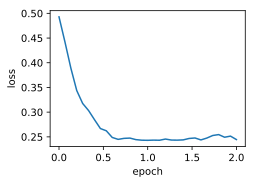

In [87]:
train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

## Adam

In [88]:
def init_adam_states():
    v_w, v_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    return (v_w, s_w), (v_b, s_b)


def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v = beta1 * v + (1 - beta1) * p.grad
        s = beta2 * s + (1 - beta2) * p.grad ** 2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p -= hyperparams['lr'] * v_bias_corr / (nd.sqrt(s_bias_corr) + eps)
        hyperparams['t'] += 1

loss: 0.259891, 0.239256 sec per epoch


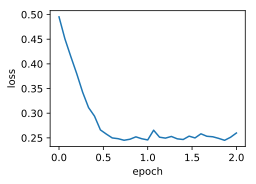

In [90]:
train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)